![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

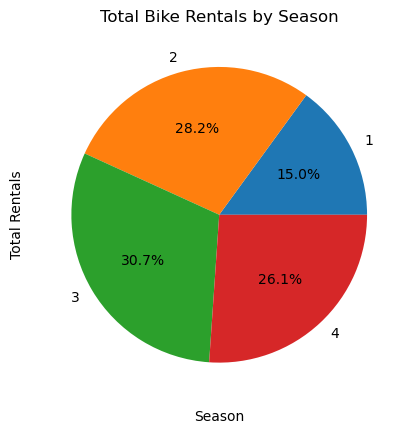

In [6]:
# Gráfico de barras de pasajeros del Titanic
import matplotlib.pyplot as plt

# assuming 'bikes' is your dataframe and you have already performed the groupby operation
bikes_season_totals = bikes.groupby('season')['total'].sum()

# plot the result as a bar chart
bikes_season_totals.plot(kind='pie',autopct='%1.1f%%')

# set the chart title and axis labels
plt.title('Total Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Total Rentals')

# show the chart
plt.show()

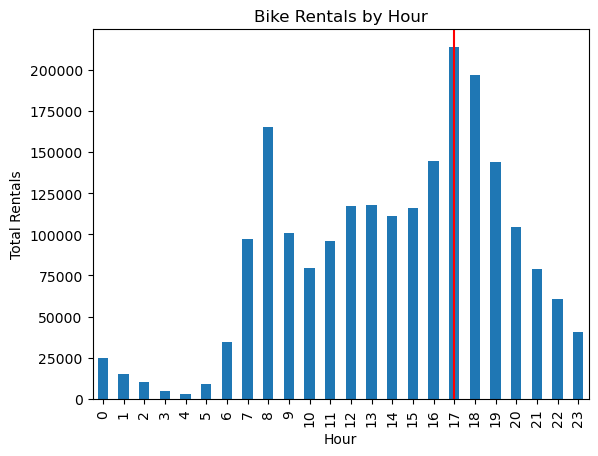

In [7]:
# assuming 'bikes' is your dataframe
hourly_totals = bikes.groupby('hour')['total'].sum()

# find the hour with the most rentals
hour_with_most_rentals = hourly_totals.idxmax()

# create a bar chart of the hourly totals
hourly_totals.plot(kind='bar')

# set the chart title and axis labels
plt.title('Bike Rentals by Hour')
plt.xlabel('Hour')
plt.ylabel('Total Rentals')

# add a vertical line to show the hour with the most rentals
plt.axvline(x=hour_with_most_rentals, color='red')

# show the chart
plt.show()

In [8]:
#Estadísticas descriptivas del dataset
pd.set_option('display.precision', 0)
bikes.describe().T.style.background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
season,10886.000000,2.506614,1.116174,1.000000,2.000000,3.000000,4.000000,4.000000
holiday,10886.000000,0.028569,0.166599,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,10886.000000,0.680875,0.466159,0.000000,0.000000,1.000000,1.000000,1.000000
weather,10886.000000,1.418427,0.633839,1.000000,1.000000,1.000000,2.000000,4.000000
temp,10886.000000,20.230860,7.791590,0.820000,13.940000,20.500000,26.240000,41.000000
atemp,10886.000000,23.655084,8.474601,0.760000,16.665000,24.240000,31.060000,45.455000
humidity,10886.000000,61.886460,19.245033,0.000000,47.000000,62.000000,77.000000,100.000000
windspeed,10886.000000,12.799395,8.164537,0.000000,7.001500,12.998000,16.997900,56.996900
casual,10886.000000,36.021955,49.960477,0.000000,4.000000,17.000000,49.000000,367.000000
registered,10886.000000,155.552177,151.039033,0.000000,36.000000,118.000000,222.000000,886.000000


### Análisis de resultados - Punto 1

Para la variable **season** tenemos 4 categorías que hacen referencia a las estaciones del año (invierno, primavera, verano y otoño). De la tabla de frecuencias, podemos ver como la estación de verano cuenta con el mayor promedio de alquiler de biciletas. Lo anterior, también se puede ver en la gráfica de torta donde verano presenta el 30.7% del alquier total de biciletas. Ahora bien, la estación que presenta la menor cantidad de biciletas alquiladas es invierno.

Para la variable **horas** tenemos 24 categorías correspondientes a las horas del día (9 a 23). De la gráfica de barras, podemos concluir que la hora en la que se demandan menos bicicletas es 4:00 AM (6,4 bicicletas en promedio se rentan a esta hora). Por otro lado, la hora que más demanda de bicicletas tiene es 5:00 PM (468 bicicletas en promedio).

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot: xlabel='hour'>

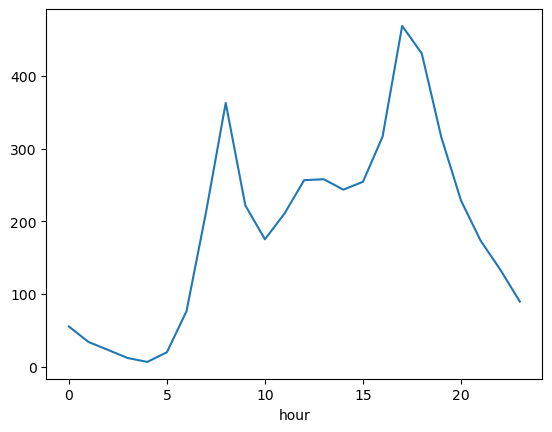

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

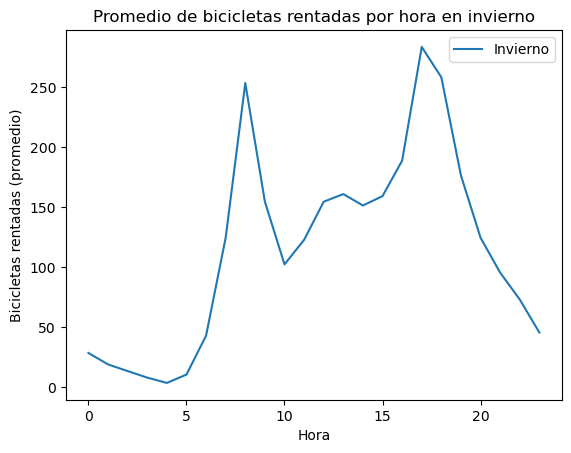

In [10]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
# filtrar datos para invierno (season=1)
data_invierno = bikes[bikes["season"] == 1]

# calcular promedio de bicicletas rentadas por hora
promedio_invierno = data_invierno.groupby("hour")["total"].mean()

# crear gráfica
plt.plot(promedio_invierno.index, promedio_invierno, label="Invierno")
plt.xlabel("Hora")
plt.ylabel("Bicicletas rentadas (promedio)")
plt.title("Promedio de bicicletas rentadas por hora en invierno")
plt.legend()
plt.show()

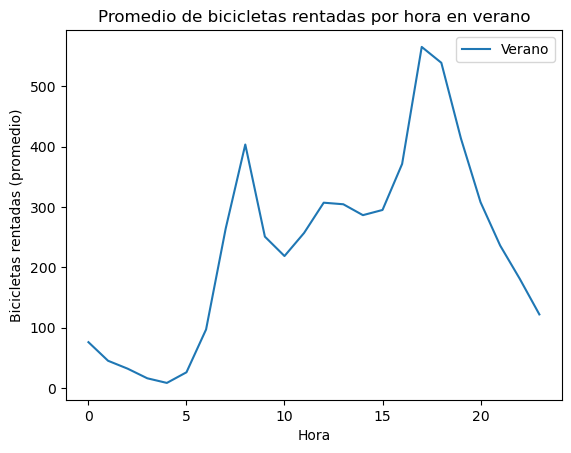

In [11]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# filtrar datos para invierno (season=1)
data_verano = bikes[bikes["season"] == 3]

# calcular promedio de bicicletas rentadas por hora
promedio_verano = data_verano.groupby("hour")["total"].mean()

# crear gráfica
plt.plot(promedio_verano.index, promedio_verano, label="Verano")
plt.xlabel("Hora")
plt.ylabel("Bicicletas rentadas (promedio)")
plt.title("Promedio de bicicletas rentadas por hora en verano")
plt.legend()
plt.show()

### Análisis de resultados - Punto 2

Al generar las gráficas correspondientes al número de bicicletas rentadas promedio para cada valor de la variable **hour** (hora) cuando la variable **season** es igual a 1 (invierno) e igual a 3 (verano), podemos concluir que entre las 4:00 pm y las 6:00 pm hay mayor alquiler de biciletas independientemente de la estación. Sin embargo, la cantidad de biciletas alquiladas si varia sustancialmente entre la estación de verano e invierno.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [14]:
# Celda 3
bikes = bikes.reset_index(drop=True)
bikes = bikes.loc[:, ['season', 'hour','total']]

#Tener en cuenta que season es una variable categorica
bikes['season'] = bikes['season'].astype('category')

X = bikes.drop(columns = "total")
X = pd.get_dummies(data=X, drop_first=True)
X.head()
y = bikes['total']
# Ajustar modelo de regresión lineal
modelo_P3 = LinearRegression().fit(X,y)

# imprimir resultados
print("Coeficientes: ", modelo_P3.coef_)
print("Intercepto: ", modelo_P3.intercept_)
print("R-cuadrado: ", modelo_P3.score(X,y))

Coeficientes:  [ 10.54520609 100.31723192 119.46754995  84.08311787]
Intercepto:  -6.430262462305961
R-cuadrado:  0.22339339904452493


In [15]:
coeff_parameter = pd.DataFrame(modelo_P3.coef_,X.columns,columns=['Coefficient'])
coeff_parameter = coeff_parameter.style.format('{:.2f}')
coeff_parameter

,Coefficient
hour,10.55
season_2,100.32
season_3,119.47
season_4,84.08


In [16]:
from sklearn.metrics import mean_squared_error
# Make predictions on the training data
y_pred = modelo_P3.predict(X)

# Calculate the mean squared error
MSE_LR = mean_squared_error(bikes['total'], y_pred)
MSE_LR

25480.694694371625

#### Análisis de resultados - Punto 3

Para interpretar los coeficientes del modelo re regresión lineal es necesario considerar la dirección de la relación entre una variable predictiva y la variable de respuesta. Un signo positivo indica que a medida que aumenta la variable predictora, también aumenta la variable objetivo. En cambio, un signo negativo indica que a medida que aumenta la variable predictora, disminuye la variable objetivo.

Ahora bien, para la variable de **hour** podemos interpretar que representa el cambio en Y asociado a un aumento de una unidad en X, manteniendo constantes todas las demás variables, es decir, el cambio en el alquiler de bicicletas si cambiamos 1 hora.

Por otro lado, la variable **season** es una variable categorica. De esta manera, su interpretación es diferente a la variable de **hour**. La interpretación del coeficiente beta para *season_2* representa la diferencia en el valor medio de Y (Alquiler de bicicletas) entre la categoría de referencia (season_1) y la categoría *season_2* de la variable categórica **season**, manteniendo todas las demás variables constantes. Del mismo modo, la interpretación del coeficiente beta para *season_3* representa la diferencia en el valor medio de Y(Alquiler de bicicletas) entre la categoría de referencia (season_1) y la categoría *season_3* de la variable categórica **season**, manteniendo constantes todas las demás variables. Lo anterior, se puede aplicar para obtener la interpretación del beta de *season_4*.

Una de las limitaciones del modelo de regresión lineal es que no es directamente interpretable cuando se tienen una variable con varias categorías.

### Definir las variables predictoras y la variable de respuesta 
Se utiliza "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Además, se dividen los datos en conjuntos de entrenamiento y prueba.

In [20]:
bikes = bikes.reset_index(drop=True)
bikes = bikes.loc[:, ['season', 'hour','total']]

#Tener en cuenta que season la convierto a numero 
bikes['season'] = bikes['season'].astype('int')

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(bikes.drop(columns = "total"),bikes['total'])

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4



In [53]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def MSE_split(j):

    # División de la variable Hits en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
    splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
    splits = np.unique(splits)
    
    min_MSExSplit = []
    
    for split in splits: 
        filter_l = X_train.iloc[:, j] < split
        y_l = y_train.loc[filter_l]
        y_r = y_train.loc[~filter_l]

        predict_l = np.average(y_l) # Prediccion de la particion l
        predict_r = np.average(y_r) # Predicción de la partición r
        
        MSE_l = np.average( np.square(predict_l - y_l) )
        MSE_r = np.average( np.square(predict_r - y_r) )
        
        min_MSExSplit.append(min(MSE_l,MSE_r))
        
    df_min_MSE = pd.DataFrame([splits, min_MSExSplit]).T.rename({0:'Splits',1:'MSE_split'},axis=1)
    best_split = df_min_MSE.loc[df_min_MSE['MSE_split'].idxmin()]['Splits']
    best_MSE = df_min_MSE.loc[df_min_MSE['MSE_split'].idxmin()]['MSE_split']

    return  best_split,best_MSE


In [54]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, num_pct=10):
    
    features = range(X.shape[1])
    
    lista_split_particion = []
    # Para todas las varibles 
    for j in features:
        #Esta función me devuelve para cada variable cual es la mejor partición y su MSE
        MSExsplitxvariable = MSE_split(j)
        lista_split_particion.append(MSExsplitxvariable)
    
    df_j_splits = pd.DataFrame(lista_split_particion, columns=[ 'Splits', 'MSE_split'])
    
    j_feature = pd.DataFrame(features, columns=['Variable'])

    df_best_split = pd.concat([j_feature, df_j_splits],axis = 1)
    
    best_MSE = df_best_split.loc[df_best_split['MSE_split'].idxmin()]['MSE_split']
    best_split = df_best_split.loc[df_best_split['MSE_split'].idxmin()]['Splits']
    best_j = df_best_split.loc[df_best_split['MSE_split'].idxmin()]['Variable']
    
    best_split = [best_j, best_split, best_MSE]  # j, split, MSE
    
    return best_split

In [55]:
best_split(X_train, num_pct=10)

[1.0, 4.0, 1156.9505659924578]

In [59]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Calcular la mejor división
    j, split, MSE = best_split(X, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [ ]:
# Celda 5
from sklearn.tree import DecisionTreeRegressor # árbol de decisión para regresión
from sklearn.model_selection import cross_val_score

#Definimos el algoritmo a utilizar
tree_P5 = DecisionTreeRegressor(max_depth = 6)

#Entrenamos el modelo
tree_P5.fit(X_train, y_train)

### Calibración

In [ ]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del MSE para cada valor de máxima profundidad (max_depth)
mse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()*-1)

print("Calibracion del parametro max_depth")
# Gráfica max_depth versus MSE (error del modelo)
plt.plot(max_depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.show()

In [ ]:
# Estructura del árbol creado
print(f"Profundidad del árbol: {tree_P5.get_depth()}")
print(f"Número de nodos terminales: {tree_P5.get_n_leaves()}")

In [ ]:
# Mejor MSE (desempeño del modelo) y su correspondiente max_depth
MSE_Tree = sorted(zip(mse_scores, max_depth_range), reverse = True)[::-1][0]
MSE_Tree

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,0.8])
ax.set_title("Comparación de modelos")
ejeX = ['Linear Regression', 'Decision Tree Regressor']
ejeY = [round(MSE_LR,2),round(MSE_Tree[0],2)]
ax.bar(ejeX,ejeY)

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
        
addlabels(ejeX,ejeY,plt)
plt.show()

index = int([np.argmin(ejeY)][0])
if index == 0:
    strDecision = "Regresión linear"
if index == 1:
    strDecision = "Arbol de decisión"
print("")
print('El mejor modelo es: ' + strDecision )
print("")

### Análisis de resultados - Punto 5

Se entrenó un árbol de decisiones con la **librería sklearn**, usando las variables predictoras *season* y *hour*. Además, se calibraron los parámetros refentes a la máxima profundidad del arbol. La profundidad que minimiza el MSE es igual a 9, con un MSE de 13132. Teniendo en cuenta la gráfica de barras presentada que compara el modelo del arbol de decisión con el modelo de regresión linear realizado en el Punto 3, podemos concluir que el mejor modelo es el **árbol de decisión** pues presenta un menor MSE.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [ ]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

In [ ]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Arbol de decisión --------------------------------------------------------------------------------------------------------
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
print("La maxima profundidad del arbol que tiene el mayor Accuracy es: " +  str(sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]))
print("")
print("El Accuracy del árbol calibrado es " +  str(sorted(zip(accuracy_scores, max_depth_range))[::-1][0][0]))
print("")
#Predecir la variable y con el arbol de desicion calibrado
y_predTree = DecisionTreeClassifier(max_depth= sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1] , random_state=1).fit(X, y).predict(X_test)
print("El F1-Score para el modelo de árbol es "+ str(metrics.f1_score(y_predTree, y_test)))

In [ ]:
# Regresión logística ------------------------------------------------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
print("Estimando Modelo de Regresión logística")

clfRegLog= LogisticRegression(random_state=0,max_iter=10000) # Generar un modelo
clfRegLog.fit(X_train,y_train) #Estimar el modelo 
y_predReglog = clfRegLog.predict(X_test) #Predecir con el modelo de regresion logistica
print("Modelo estimado")
print("")
print("El Acurracy del modelo de regresión logística es " +  str(metrics.accuracy_score(y_predReglog, y_test)))
print("El F1-Score para el modelo de regresión logística es "+ str(metrics.f1_score(y_predReglog, y_test)))
print("\n")


### Análisis de resultados - Punto 6 

En ese numeral, se construyeron 2 modelos: un árbol de decisión y una regresión logística. Para el árbol, se calibró el criterio de parada de máxima profundidad (max_depth). Obteniendo que la maxima profundidad del arbol que tiene el mayor Accuracy es: 2. 

Ahora bien, se evaluó el desempeño de cada modelo usando las métricas de Accuracy y F1-Score. El Accuracy y el F1-Score son dos métricas utilizadas habitualmente para evaluar el rendimiento de un modelo de clasificación. El Accuracy es la proporción de instancias clasificadas correctamente sobre el número total de instancias del conjunto de datos. Mide la frecuencia con la que el modelo predice correctamente la clase verdadera de una instancia. Teniendo en cuenta el accuracy de cada modelo, podemos concluir que el árbol de decisión presenta una puntuación de precisión más alta que el modelo de regresión logística así indica que el modelo funciona mejor a la hora de clasificar correctamente los casos.

El F1-Score es la media armónica de la precisión y la recuperación, otras dos métricas utilizadas habitualmente para los modelos de clasificación. La precisión mide la proporción de predicciones positivas verdaderas sobre todas las predicciones positivas, mientras que la recuperación mide la proporción de predicciones positivas verdaderas sobre todas las predicciones positivas reales del conjunto de datos. La puntuación F1 equilibra estas dos métricas, proporcionando una única puntuación que refleja tanto la precisión como la recuperación. Teniendo en cuenta el F1-Score de cada modelo, podemos concluir que el modelo del árbol de decisión tiene un F1-Score más alto que el modelo de regresión logística así tiene un mejor equilibrio entre precisión y recuperación que la regresión logística.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [ ]:
# Celda 7

from sklearn.ensemble import BaggingClassifier

# Uso de BaggingRegressor de la libreria (sklearn) para estimar los diferentes modelos. 

bagg100TreeDepth2 = BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators = 100, 
                          bootstrap=True, oob_score=True , max_samples = 300, random_state=1,n_jobs=-1)

bagg100TreeMinSampleLeaf = BaggingClassifier(DecisionTreeClassifier(max_depth=None,min_samples_leaf=6), n_estimators = 100, 
                          bootstrap=True, oob_score=True , max_samples = 300, random_state=1,n_jobs=-1)

bagg100RegLog = BaggingClassifier(LogisticRegression(random_state=1,max_iter=1000), n_estimators = 100, 
                          bootstrap=True, oob_score=True , max_samples = 300, random_state=1,n_jobs=-1)


In [ ]:
# Entrenemiento de los modelos con set de entrenamiento y predicción en el set de test

print('\n')
print("Entrenamos modelo Tree Depth = 2")
bagg100TreeDepth2.fit(X_train, y_train)
y_predbagg100TreeDepth2 = bagg100TreeDepth2.predict(X_test)
print('Modelo Entrenado')
print("")
print('El F1-Score y el Acurracy del modelo bagging de Árbol con MaxDepth = 2 son respectivamente')
print(metrics.f1_score(y_predbagg100TreeDepth2, y_test), metrics.accuracy_score(y_predbagg100TreeDepth2, y_test))

print('\n')
print("Entrenamos modelo Tree min samples leaf = 10")
bagg100TreeMinSampleLeaf.fit(X_train, y_train)
y_predbagg100MinSampleLeaf = bagg100TreeMinSampleLeaf.predict(X_test)
print('Modelo Entrenado')
print("")
print('El F1-Score y el Acurracy del modelo bagging de Árbol con min samples leaf = 10 son respectivamente')
print(metrics.f1_score(y_predbagg100MinSampleLeaf, y_test), metrics.accuracy_score(y_predbagg100MinSampleLeaf, y_test))

print('\n')
print("Entrenamos modelo Reg Logística")
bagg100RegLog.fit(X_train, y_train)
y_predbagg100RegLog = bagg100RegLog.predict(X_test)
print('Modelo Entrenado')
print("")
print('El F1-Score y el Acurracy del modelo Reg Logística son respectivamente')
print(metrics.f1_score(y_predbagg100RegLog, y_test), metrics.accuracy_score(y_predbagg100RegLog, y_test))

### Análisis de resultados - Punto 7

Teniendo en cuenta los resultados, podemos concluir que según las métricas F1_Score y Acurracy, el mejor modelo de los 3 ensamblajes presentados es el modelo **Bagging Árbol de decisión con mínimo número de hojas de 10 con votación mayoritaria** 

Cabe mencionar que, establecer un valor más alto para min_samples_leaf para los árboles de decisión individuales puede conducir a un conjunto más robusto y menos sobreajustado. Sin embargo, también puede conducir a un mayor sesgo en el modelo, ya que los árboles de decisión pueden no ser capaces de capturar toda la complejidad de los datos con menos nodos hoja. 

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8

#Votación ponderada para el modelo bagging de Árbol con MaxDepth = 2
errors = np.zeros(bagg100TreeDepth2.n_estimators)
y_pred_all_ = np.zeros( (X_test.shape[0], bagg100TreeDepth2.n_estimators) )
for i in range(bagg100TreeDepth2.n_estimators):
    oob_sample = ~bagg100TreeDepth2.estimators_samples_[i]
    y_pred_ = bagg100TreeDepth2.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = bagg100TreeDepth2.estimators_[i].predict(X_test)
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
# Metricas con votación ponderada
print('El F1-Score y el Acurracy del modelo bagging de Árbol con MaxDepth = 2 y votación ponderada son respectivamente')
print(metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

print('\n')
#Votación ponderada para el modelo bagging de Árbol con min samples leaf = 10
errors = np.zeros(bagg100TreeMinSampleLeaf.n_estimators)
y_pred_all_ = np.zeros( (X_test.shape[0], bagg100TreeMinSampleLeaf.n_estimators) )

for i in range(bagg100TreeMinSampleLeaf.n_estimators):
    oob_sample = ~bagg100TreeMinSampleLeaf.estimators_samples_[i]
    y_pred_ = bagg100TreeMinSampleLeaf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = bagg100TreeMinSampleLeaf.estimators_[i].predict(X_test)
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
# Metricas con votación ponderada
print('El F1-Score y el Acurracy del modelo bagging de Árbol min samples leaf = 10 y votación ponderada son respectivamente')
print(metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

print('\n')
#Votación ponderada para el modelo Reg Logística
errors = np.zeros(bagg100RegLog.n_estimators)
y_pred_all_ = np.zeros( (X_test.shape[0], bagg100RegLog.n_estimators) )

for i in range(bagg100RegLog.n_estimators):
    oob_sample = ~bagg100RegLog.estimators_samples_[i]
    y_pred_ = bagg100RegLog.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = bagg100RegLog.estimators_[i].predict(X_test)  
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
# Metricas con votación ponderada
print('El F1-Score y el Acurracy del modelo regresión logística con votación ponderada son respectivamente')
print(metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))


### Análisis de resultados - Punto 8

Teniendo en cuenta los resultados, podemos concluir que según la métrica del Acurracy, el mejor modelo de los 3 ensamblajes presentados es el modelo **Bagging Árbol de decisión con mínimo número de hojas de 10 con votación ponderada**. Por otro lado, según la métrica del F1-Score, el mejor modelo de los 3 ensamblajes presentados es el modelo **Bagging Árbol de decisión con profundidad máxima de 2 con votación ponderada**.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

# Celda 9

En los numerales 7 y 8, se generaron los siguientes ensamblajes con diferentes tipos de clasificadores:

1. 100 árboles de decisión donde max_depth tome un valor de su elección\
2. 100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
3. 100 regresiones logísticas

Para cada clasificador se generaron 300 muestras a partir de bootstrap. Finalmente, pare realizar la predicción de cada ensamblaje se propuso: 
 
 **En el punto 7:** Las predicciones se realizaron por el método de **votación mayoritaria**, es decir, se escoge como predicción final aquella clase que tenga la mayoría de las predicciones a su favor. Esto quiere decir que se le da el mismo "peso" a todas las predicciones sin importar el error de cada modelo. 
 
 **En el punto 8:** Las predicciones se hicieron por el método de **votación ponderada**, esto significa que la predicción final depende de una ponderación porcentual de todas las predicciones. Aquellas predicciones que aportan *más* a la predicción final son las que vienen de un modelo con error OOB bajo. De igual manera, las predicciones que *menos* aportan a la predicción final son aquellas que tiene un error OOB mayor.
 
Teniendo en cuenta los resultados obtenidos en los numerales 7 y 8, podemos concluir que no para los 3 ensamblajes las métricas estan mejorando. En general, la mejora en las métricas es pequeña y son mayores en **votación mayoritaria**. Lo anteior, puede deberse a que si los modelos base tienen un rendimiento similar, la votación mayoritaria puede ser suficiente para reducir la varianza y mejorar la precisión general del modelo de ensamble. 

Ahora bien, la metodología de Bagging por votación mayoritaria puede funcionar bien cuando las clases están equilibradas en el conjunto de datos. Sin embargo, puede no ser óptimo en situaciones de clases desequilibradas, ya que los modelos que predicen la clase mayoritaria pueden dominar la votación y dar lugar a resultados sesgados. También, hay que considerar que los modelos que tienen un rendimiento inferior pueden reducir la precisión global de la predicción.

Por otro lado, la metodolgía de Bagging por votación ponderada permite que los modelos más confiables tengan un mayor peso en la votación final.Así, puede manejar mejor situaciones de clases desequilibradas que la votación mayoritaria. Sin embargo, es necesario mencionar que puede ser difícil determinar la ponderación adecuada para cada modelo. También, puede tener un rendimiento inferior a la votación mayoritaria cuando los modelos son similares en rendimiento.